# Quantum Circuits using Qiskit

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.compiler import transpile
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import *
from qiskit.quantum_info import *

## Quantum counterparts to Classical Logic Operations
Some of the basic logic operations are NOT, AND and OR. We can create quantum versions of these operations if we keep in mind that the operation has to be unitary. We can also think of it in terms of reversible operations. To implement a quantum version of a classical logic operation, we need to create a reversible version of the classical operation first and then find the quantum gates that can implement the operation on a quantum computer

### NOT
The NOT operation is pretty simple, since it is already reversible. The quantum version of the classical NOT operation is the $X$ gate. It is equivalent to the classical operation only in the sense that it takes a $|0\rangle$ to a $|1\rangle$ and vice versa. It is not a generalised inversion operation. 

We can directly apply the $X$ gate on a qubit as an analog to the classical operation because the classical NOT is a one-to-one function and hence is reversible by default

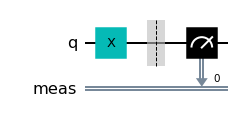

In [2]:
qc1 = QuantumCircuit(1)
qc1.x(0)
qc1.measure_all()
qc1.draw(output='mpl')

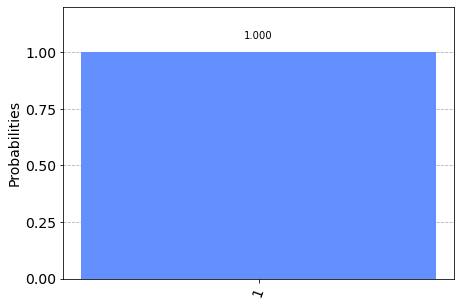

In [3]:
job1 = execute(qc1, backend=QasmSimulator(), shots=1024)
plot_histogram(job1.result().get_counts())

## XOR

The exclusive-OR or simply XOR is one of the simplest logic operations. It is also a binary operation, which means that there are two inputs. The output is `True` or `1` if only one of the inputs is `1`. 

| x 	| y 	| x $\oplus$ y |
|---	|---	|-----	|
| 0 	| 0 	| 0   	|
| 0 	| 1 	| 1   	|
| 1 	| 0 	| 1   	|
| 1 	| 1 	| 0   	|

This is not one-to-one. However, if we restrict one of the inputs to a specific value, the function with one fixed input is one-to-one, and hence reversible. 
It is easy to see that the $x\oplus 0 = x$ and $x \oplus 1 = \bar{x}$. We can see that the CNOT operation on a quantum computer emulates precisely this operation. Let us look at $x\oplus 0 = x$ below. This is implemented in the form of the qubit transformation 
$$|x\rangle |0\rangle \xrightarrow{\text{CNOT}} |x\rangle|0 \oplus x\rangle$$

<div class="alert alert-block alert-danger"><b>Warning: </b>This is only valid when x is 0 or 1. We cannot copy an arbitrary state because it violates the No-cloning principle </div>


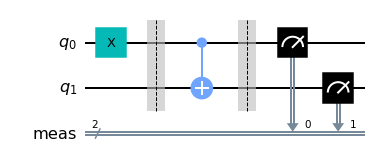

In [4]:
qc2 = QuantumCircuit(2)
# State Preparation
qc2.x(0)
qc2.barrier()
# Perform q_0 XOR 0
qc2.cx(0,1)
qc2.measure_all()
qc2.draw(output='mpl')

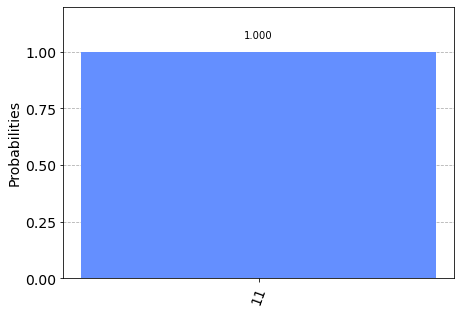

In [5]:
job2 = execute(qc2.reverse_bits(), backend=QasmSimulator(), shots=1024)
plot_histogram(job2.result().get_counts())

This is a general pattern we follow for reversible operations. while the logic operation itself is not reversible, the transformation that takes each $|x\rangle |0\rangle$ to $|x\rangle |0\oplus f(x)\rangle$ and $|x\rangle |1\rangle$ to $|x\rangle |1\oplus f(x)\rangle$ will generally be reversible and can be implemented as a quantum computer. 
## AND 
The AND operation is slightly more involved. 

| x 	| y 	| x $\cdot$ y |
|---	|---	|-----	|
| 0 	| 0 	| 0   	|
| 0 	| 1 	| 0   	|
| 1 	| 0 	| 0   	|
| 1 	| 1 	| 1   	|

From the table above, it looks like this might be achieved via some kind of a CNOT gate, but with two controls. This is called a Toffoli gate (also called a CCNOT or CCX gate). The operation works for the basis states
$$|x\rangle |y\rangle |0\rangle \xrightarrow{\text{CCNOT}} |x\rangle |y\rangle |0 \oplus x\cdot y \rangle$$

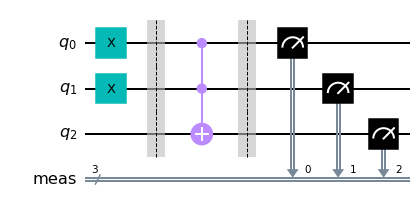

In [6]:
qc3 = QuantumCircuit(3)
# State Preparation
qc3.x(0)
qc3.x(1)
qc3.barrier()
# Perform q_0 XOR 0
qc3.ccx(0,1,2)
qc3.measure_all()
qc3.draw(output='mpl')

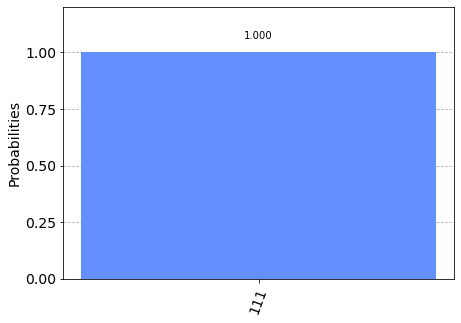

In [7]:
job3 = execute(qc3.reverse_bits(), backend=QasmSimulator(), shots=1024)
plot_histogram(job3.result().get_counts())

## Creating Uniform Superpositions

Due to linearity, superpositions become a very powerful tool in quantum computing. Once we can create oracles, we can 'push' a superposition through an oracle to obtain a superposition of the function outputs for each state in that superposition. Quantum algorithm exploit this very kind of 'parallelism'. We will just see how to create a uniform superposition now. 

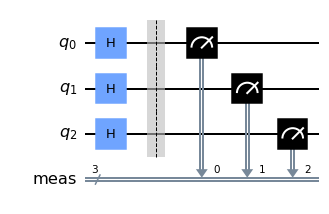

In [8]:
qc4 = QuantumCircuit(3)
# State Preparation
qc4.h(range(3))


qc4.measure_all()
qc4.draw(output='mpl')

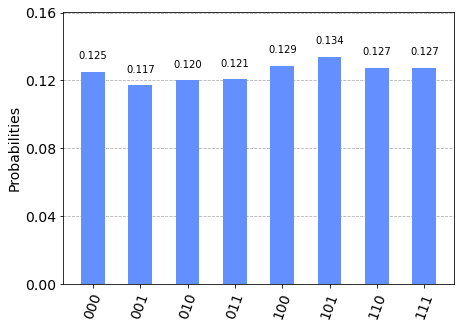

In [9]:
job4 = execute(qc4.reverse_bits(), backend=QasmSimulator(), shots=8192)
plot_histogram(job4.result().get_counts())

## Noise on Quantum Computers

Modern quantum hardware is noisy. Any result you get from a job you give to an IBMQ will be different from the result you get from the simulator. 
Due to fair-share restrictions, we will be using a noisy simulation to see the difference. 

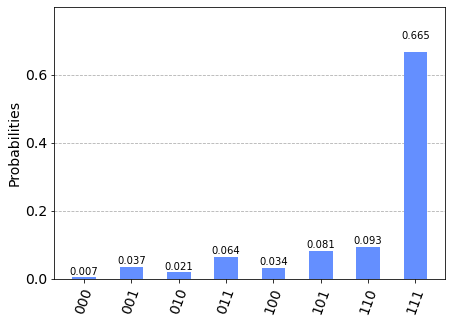

In [14]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeMelbourne
device_backend = FakeMelbourne()
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates
result_noise = execute(qc3, QasmSimulator(),
                       shots=8192,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
plot_histogram(result_noise.get_counts())

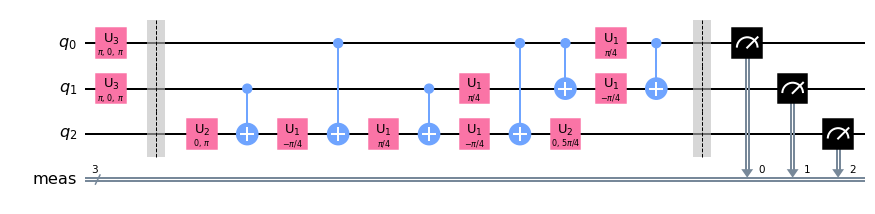

In [11]:
qc3_t = transpile(qc3, basis_gates=basis_gates)
qc3_t.draw(output='mpl')

## Accessing IBM Quantum backends
The following code cells will work without changes on IBM Quantum Lab. If you want to run this locally or in Binder, please refer to these [instructions](https://qiskit.org/documentation/install.html#install-access-ibm-q-devices-label).

In [12]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider.backends()

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [ ]:
ibmq_backend = provider.get_backend('ibmq_lima')
result_device = execute(qc3t, backend=ibmq_backend, shots=8192).result()

In [ ]:
plot_histogram(result_device.get_counts())